# Import Necessary Packages & Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from math import pi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

First we'll read in the data from the World Banks world development indicator dataset.  The income groups are read in separately so that we may deal with missing values as they pertain to each income group to prevent filling values with what would become outliers for each income group as a whole.

In [2]:
# Read in data

# WDI with NaN values
wdi_nan = pd.read_csv('WDI_csv/wrangled/wdi_pivot.csv')

# WDI income groups, used to fill nan values
high = pd.read_csv('WDI_csv/eda/high.csv')
um = pd.read_csv('WDI_csv/eda/upper_middle.csv')
lm = pd.read_csv('WDI_csv/eda/lower_middle.csv')
low = pd.read_csv('WDI_csv/eda/low.csv')
corr = pd.read_csv('WDI_csv/eda/wdi_corr.csv')

# Get rid of 'unnamed: 0' columns
wdi_nan = wdi_nan.iloc[:,1:]
high = high.iloc[:,2:]
um = um.iloc[:,2:]
lm = lm.iloc[:,2:]
low = low.iloc[:,2:]
corr = corr.iloc[:,1:]

income_groups = [high, um, lm, low]

# Define Functions for Model Training

In [136]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         subplot=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = wdi_ml.ig.unique()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def select_model(features, model):
    '''This function trains and predicts a multiclass classification model and displays its score'''
    
    # Fit model
    clf = model.fit(Xn_train[features], y_train)
    
    # Make predictions
    y_predict = clf.predict(Xn_test[features])
    
    # Score model
    print('Accuracy: {}'.format(accuracy_score(y_test, y_predict)))
    print(classification_report(y_test, y_predict))
    
    # Create dataframe of scored model
    global dataframe
    dataframe = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).transpose()
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=wdi_ml.ig,
                          title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=wdi_ml.ig, normalize=True,
                          title='Normalized confusion matrix')

    
def select_models(features, model):
    '''This function trains and predicts a multiclass classification model with various 
    types of features and displays its score'''

    # Fit model
    clf = model.fit(Xn_train[features], y_train)
    
    # Make predictions
    y_predict = clf.predict(Xn_test[features])
    
    # Score model
    print('Accuracy: {}'.format(accuracy_score(y_test, y_predict)))
    
    
def spider_plot():
    '''This plots the comparison between models of their various 
    scores averaged as a while and between each income group'''
    # ------- PART 1: Create background
         
    # number of variable
    categories=list(average)
    N = len(categories)
         
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
         
    # Parameters for for loop
    params = [list((np.linspace(0.955,0.985,3))), list((np.linspace(0.84,0.928,3))), 
              list((np.linspace(0.9,0.93,3))), list((np.linspace(0.92,0.995,3)))]
    begs = [0.955, 0.84, 0.85, 0.92]
    ends = [0.99, 0.93, 0.928, 0.995]
    labels = ['f1-score', 'precision', 'recall']
    ii = [221,222,223,224]
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111, polar=True)
     
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
     
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(list(np.linspace(0.9,0.942,3)), color="grey", size=7)
    plt.ylim(0.9,0.942)
     
     
    # ------- PART 2: Add plots
     
    # Plot each individual = each line of the data
     
    # Ind1
    values=average.loc['f1-score'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="f1-score")
    ax.fill(angles, values, 'b', alpha=0.1)
     
    # Ind2
    values=average.loc['precision'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="precision")
    ax.fill(angles, values, 'r', alpha=0.1)
    
    # Ind3
    values=average.loc['recall'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="recall")
    ax.fill(angles, values, 'y', alpha=0.1)
    
    # Ind4
    values=average.loc['accuracy'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="accuracy")
    ax.fill(angles, values, 'y', alpha=0.1)
    
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()
    
    plt.figure(figsize=(10,10))
    
    # number of variable
    categories=list(high_score)
    N = len(categories)
         
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Plot subplots
    for score, param, i, beg, end in zip(scores, params, ii, begs, ends):
        
        # Initialise the spider plot
        ax = plt.subplot(i, polar=True)
         
        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
         
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories)
         
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(param, color="grey", size=7)
        plt.ylim(beg, end)
         
         
        # ------- PART 2: Add plots
         
        # Plot each individual = each line of the data
         
        # Ind1
        values=score.loc['f1-score'].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label="f1-score")
        ax.fill(angles, values, 'b', alpha=0.1)
         
        # Ind2
        values=score.loc['precision'].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label="precision")
        ax.fill(angles, values, 'r', alpha=0.1)
        
        # Ind3
        values=score.loc['recall'].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label="recall")
        ax.fill(angles, values, 'y', alpha=0.1)
        
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    plt.show()

# Fill Missing Data

Percent of missing data: 0.08448640307081814


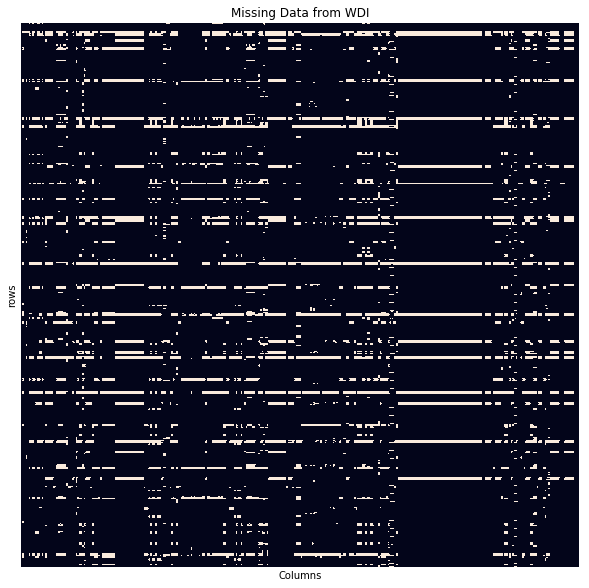

In [101]:
# Percent of total NaN values
print('Percent of missing data: {}'.
      format(wdi_nan.isnull().sum().sum()/wdi_nan.count().sum()))

# Plot Visual of Nan Values
plt.subplots(figsize=(10,10))
sns.heatmap(wdi_nan.isnull(), cbar=False)
plt.title('Missing Data from WDI')
plt.xticks([])
plt.xlabel('Columns')
plt.yticks([])
plt.ylabel('rows')
plt.show()

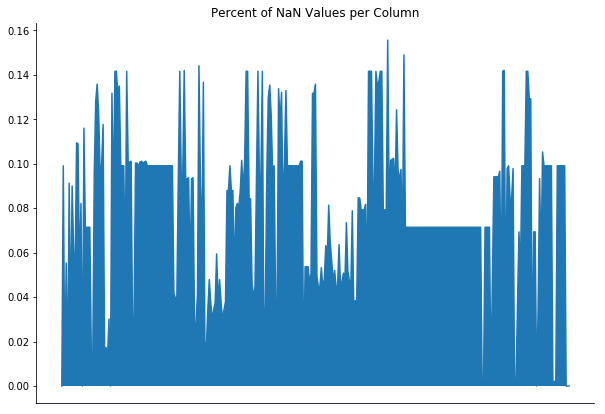

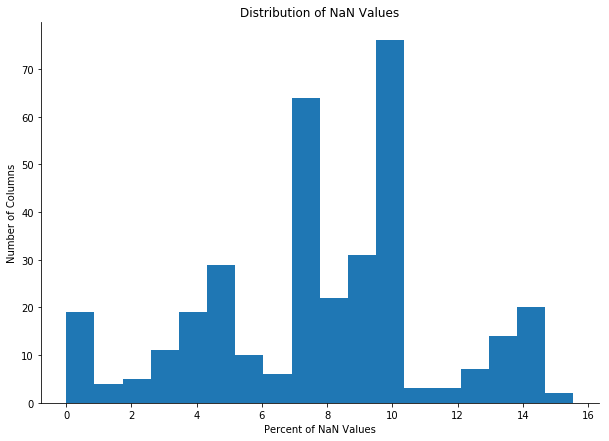

In [103]:
# Plot Nan Values
plt.figure(figsize=(10,7))
plt.plot(wdi_nan.columns, wdi_nan.isnull().sum()/len(wdi_nan*100))
plt.title('Percent of NaN Values per Column')
plt.fill_between(wdi_nan.columns, wdi_nan.isnull().sum()/len(wdi_nan*100))
plt.xticks([])
sns.despine(right=True, top=True)
plt.show()

# Plot Distribution of Nan Values
plt.figure(figsize=(10,7))
plt.hist(wdi_nan.isnull().sum()/len(wdi_nan)*100, bins=int(np.sqrt(len(wdi_nan.columns))))
plt.title('Distribution of NaN Values')
plt.ylabel('Number of Columns')
plt.xlabel('Percent of NaN Values')
sns.despine(right=True, top=True)
plt.show()

In [6]:
# Impute mean of each income group
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Create arrays of imputed data
hi = imp.fit_transform(high.iloc[:,1:-2])
umi = imp.fit_transform(um.iloc[:,1:-2])
lmi = imp.fit_transform(lm.iloc[:,1:-2])
li = imp.fit_transform(low.iloc[:,1:-2])

# Combine all the imputed arrays
imputed = [hi, umi, lmi, li]
df = np.concatenate(imputed)

# Display imputed arrays as a dataframe
pd.DataFrame(df).head()

,0,1,2,3,4,5,6,7,8,9,...,332,333,334,335,336,337,338,339,340,341
0,100.0,100.0,100.0,100.0,0.929617,1.082294e+07,14.73613,3.276689e+08,1.540000,3.963305e+10,...,71205.0,90.285,2.867779,8.991638,12.042677,10.671818,88.980094,82.714683,85.497288,2005.0
1,100.0,100.0,100.0,100.0,0.929617,1.092228e+07,14.73613,3.563753e+08,2.050000,3.963305e+10,...,72736.0,89.807,2.127341,8.991638,12.042677,10.671818,88.980094,82.714683,85.497288,2006.0
2,100.0,100.0,100.0,100.0,0.929617,1.134801e+07,14.73613,4.020048e+08,2.457334,3.963305e+10,...,73843.0,89.308,1.510477,8.991638,12.042677,10.671818,88.980094,82.714683,85.497288,2007.0
3,100.0,100.0,100.0,100.0,0.929617,1.192867e+07,14.73613,3.958014e+08,2.864667,3.963305e+10,...,74640.0,89.004,1.073534,8.991638,12.042677,10.671818,88.980094,82.714683,85.497288,2008.0
4,100.0,100.0,100.0,100.0,0.929617,1.186081e+07,14.73613,3.531595e+08,3.140000,3.963305e+10,...,75097.0,88.912,0.610405,8.991638,12.042677,10.671818,88.980094,82.714683,85.497288,2009.0


In [7]:
# Combine income groups into dataframe in the same order as imputed arrays
wdi = pd.concat([high, um, lm, low])

# Replace all numerical values in dataframe with imputed arrays
wdi.iloc[:, 1:-2] = df

# Display before and after imputation
print(wdi_nan.isnull().sum().head())
wdi.isnull().sum().head()

country                                                                   0
Access to clean fuels and technologies for cooking (% of population)    240
Access to electricity (% of population)                                  14
Access to electricity, rural (% of rural population)                    134
Access to electricity, urban (% of urban population)                     14
dtype: int64


country                                                                 0
Access to clean fuels and technologies for cooking (% of population)    0
Access to electricity (% of population)                                 0
Access to electricity, rural (% of rural population)                    0
Access to electricity, urban (% of urban population)                    0
dtype: int64

In [8]:
# Sort dataframe into original order
wdi = wdi.sort_values(['country','year'])

# View imputed dataframe
wdi.head()

,country,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: consumption of fixed capital (% of GNI),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),...,Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",year,region,income_group
0,Afghanistan,13.49,23.000000,13.000000,74.000000,1.062383,2.495481e+07,9.786023,5.806829e+08,2.604448,...,4.768647,96.667002,88.143999,90.952999,3.220,11.183,8.559,2005.0,South Asia,Low income
1,Afghanistan,14.81,28.228613,12.543863,80.042892,1.062383,3.298676e+07,9.786023,6.874334e+08,2.648119,...,4.123188,96.626999,88.017996,90.847000,3.260,11.312,8.666,2006.0,South Asia,Low income
2,Afghanistan,15.99,33.748680,18.916223,81.800255,1.062383,4.786236e+07,9.786023,9.914580e+08,2.691791,...,3.650485,96.634996,87.805997,90.691002,3.252,11.519,8.817,2007.0,South Asia,Low income
3,Afghanistan,17.44,42.400000,32.500000,89.900000,1.062383,9.307607e+07,9.786023,1.132399e+09,2.735462,...,3.404189,96.556997,87.686997,90.592003,3.329,11.643,8.920,2008.0,South Asia,Low income
4,Afghanistan,18.84,44.854885,31.845157,85.354507,1.251926,1.552841e+08,11.463860,1.421933e+09,2.779134,...,3.457099,96.557999,87.415999,90.396000,3.328,11.902,9.107,2009.0,South Asia,Low income


In [9]:
# View original dataframe
wdi_nan.head()

,country,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: consumption of fixed capital (% of GNI),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),...,Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",year,region,income_group
0,Afghanistan,13.49,23.000000,13.000000,74.000000,NaN,2.495481e+07,NaN,5.806829e+08,2.604448,...,4.768647,96.667002,88.143999,90.952999,3.220,11.183,8.559,2005,South Asia,Low income
1,Afghanistan,14.81,28.228613,12.543863,80.042892,NaN,3.298676e+07,NaN,6.874334e+08,2.648119,...,4.123188,96.626999,88.017996,90.847000,3.260,11.312,8.666,2006,South Asia,Low income
2,Afghanistan,15.99,33.748680,18.916223,81.800255,NaN,4.786236e+07,NaN,9.914580e+08,2.691791,...,3.650485,96.634996,87.805997,90.691002,3.252,11.519,8.817,2007,South Asia,Low income
3,Afghanistan,17.44,42.400000,32.500000,89.900000,NaN,9.307607e+07,NaN,1.132399e+09,2.735462,...,3.404189,96.556997,87.686997,90.592003,3.329,11.643,8.920,2008,South Asia,Low income
4,Afghanistan,18.84,44.854885,31.845157,85.354507,1.251926,1.552841e+08,11.46386,1.421933e+09,2.779134,...,3.457099,96.557999,87.415999,90.396000,3.328,11.902,9.107,2009,South Asia,Low income


In [10]:
# Percent of total NaN values
wdi.isnull().sum().sum()/wdi.count().sum()

0.0

# Give Predictors Nominal Classes, Drop Countries and Regions

In [11]:
# Create new column with the exact income group labels
wdi['ig'] = wdi['income_group']

# Assign income group labels to a number
wdi['ig'][wdi['ig'] == 'High income'] = 0
wdi['ig'][wdi['ig'] == 'Upper middle income'] = 1
wdi['ig'][wdi['ig'] == 'Lower middle income'] = 2
wdi['ig'][wdi['ig'] == 'Low income'] = 3

print(wdi.income_group.value_counts())
print(wdi.ig.value_counts())

High income            787
Lower middle income    613
Upper middle income    555
Low income             469
Name: income_group, dtype: int64
0    787
2    613
1    555
3    469
Name: ig, dtype: int64


In [12]:
# Drop countries, regions and income group labels (keep nominal labels)
wdi_ml_all = pd.concat([wdi.iloc[:,1:-3], wdi.iloc[:,-1]], axis=1)
# Convert to integers
wdi_ml_all.ig = wdi_ml_all.ig.astype('int')
target_name = wdi.iloc[:,-2:-1]

# Confirm
wdi_ml_all.head()

,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (% of GNI),Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: consumption of fixed capital (% of GNI),Adjusted savings: consumption of fixed capital (current US$),Adjusted savings: education expenditure (% of GNI),Adjusted savings: education expenditure (current US$),...,Urban population (% of total),Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",year,ig
0,13.49,23.000000,13.000000,74.000000,1.062383,2.495481e+07,9.786023,5.806829e+08,2.604448,5.628162e+08,...,22.703,4.768647,96.667002,88.143999,90.952999,3.220,11.183,8.559,2005.0,3
1,14.81,28.228613,12.543863,80.042892,1.062383,3.298676e+07,9.786023,6.874334e+08,2.648119,5.628162e+08,...,22.907,4.123188,96.626999,88.017996,90.847000,3.260,11.312,8.666,2006.0,3
2,15.99,33.748680,18.916223,81.800255,1.062383,4.786236e+07,9.786023,9.914580e+08,2.691791,5.628162e+08,...,23.113,3.650485,96.634996,87.805997,90.691002,3.252,11.519,8.817,2007.0,3
3,17.44,42.400000,32.500000,89.900000,1.062383,9.307607e+07,9.786023,1.132399e+09,2.735462,5.628162e+08,...,23.320,3.404189,96.556997,87.686997,90.592003,3.329,11.643,8.920,2008.0,3
4,18.84,44.854885,31.845157,85.354507,1.251926,1.552841e+08,11.463860,1.421933e+09,2.779134,3.447132e+08,...,23.528,3.457099,96.557999,87.415999,90.396000,3.328,11.902,9.107,2009.0,3


# Drop Columns Directly Related to Income Categories

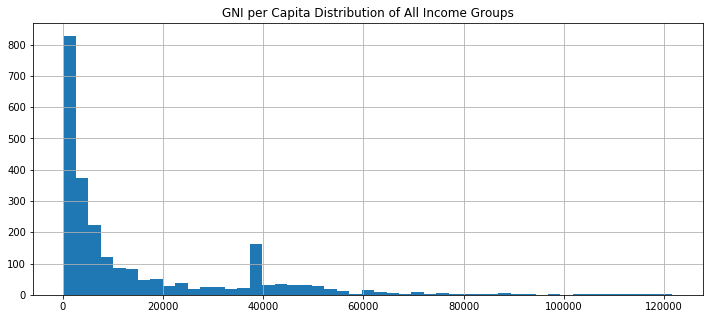

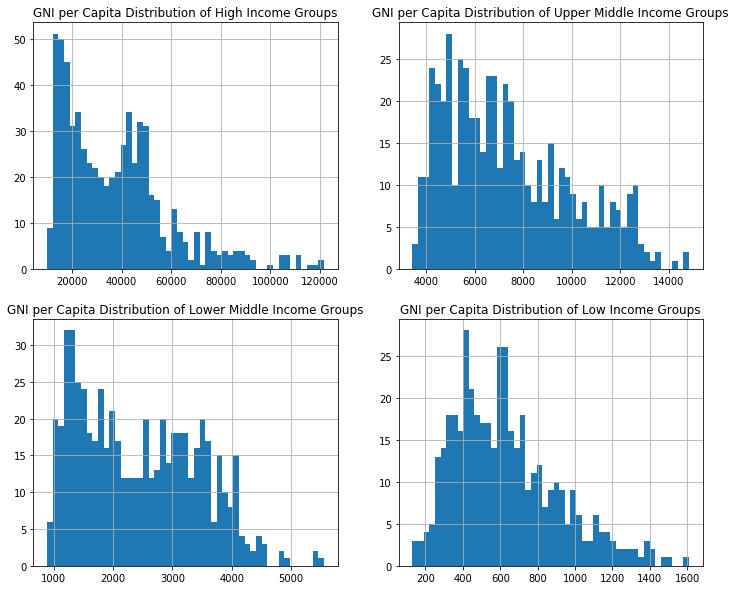

In [105]:
# Plot distribution of GNI per Capita
plt.figure(figsize=(12,5,))
wdi['GNI per capita, Atlas method (current US$)'].hist(bins=int(np.sqrt(len(wdi))))
plt.title('GNI per Capita Distribution of All Income Groups')
plt.plot

dists = [high, um, lm, low]
plots = [1,2,3,4,]
titles = ['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income']

plt.figure(figsize=(12,10,))
for plot, dist, title in zip(plots, dists, titles):
    plt.subplot(2,2,plot)
    dist['GNI per capita, Atlas method (current US$)'].hist(bins=int(np.sqrt(len(wdi))))
    plt.title('GNI per Capita Distribution of {} Groups'.format(title))

In [14]:
# Gather all GNI and GDP columns directly relate to Income Group
gni = list(wdi.columns[wdi.columns.str.contains('GNI')])[5:]
gdp = list(wdi.columns[wdi.columns.str.contains('GDP')])[8:26]

# Combine into one list
gni.extend(gdp)
gni

['GNI (current LCU)',
 'GNI (current US$)',
 'GNI per capita (current LCU)',
 'GNI per capita, Atlas method (current US$)',
 'GNI per capita, PPP (current international $)',
 'GNI, Atlas method (current US$)',
 'GNI, PPP (current international $)',
 'GDP (constant 2010 US$)',
 'GDP (constant LCU)',
 'GDP (current LCU)',
 'GDP (current US$)',
 'GDP deflator (base year varies by country)',
 'GDP deflator: linked series (base year varies by country)',
 'GDP growth (annual %)',
 'GDP per capita (constant 2010 US$)',
 'GDP per capita (constant LCU)',
 'GDP per capita (current LCU)',
 'GDP per capita (current US$)',
 'GDP per capita growth (annual %)',
 'GDP per capita, PPP (constant 2011 international $)',
 'GDP per capita, PPP (current international $)',
 'GDP per person employed (constant 2011 PPP $)',
 'GDP, PPP (constant 2011 international $)',
 'GDP, PPP (current international $)',
 'GDP: linked series (current LCU)']

In [15]:
# Drop columns
wdi_ml = wdi_ml_all.drop(gni, axis=1)

# Split Data and Normalize Train and Test Sets
We want to prevent data leakage into the test set.
Data is on several different scales

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    wdi_ml.iloc[:,:-1], wdi_ml.iloc[:,-1], test_size=0.3, random_state=10)


# Normalize training data
scaler = StandardScaler().fit(X_train)

Xn_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

# Normalize testing data by using mean and SD of training set
Xn_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# Feature Selection

Current health expenditure per capita (current US$)                                  0.065571
Employment in agriculture (% of total employment) (modeled ILO estimate)             0.039286
Population ages 0-14 (% of total)                                                    0.037108
Vulnerable employment, female (% of female employment) (modeled ILO estimate)        0.034685
Wage and salaried workers, female (% of female employment) (modeled ILO estimate)    0.031817
Population ages 5-9, female (% of female population)                                 0.028665
Individuals using the Internet (% of population)                                     0.027487
Agriculture, forestry, and fishing, value added (% of GDP)                           0.020393
Population ages 65 and above (% of total)                                            0.019770
Contributing family workers, total (% of total employment) (modeled ILO estimate)    0.019668
dtype: float64


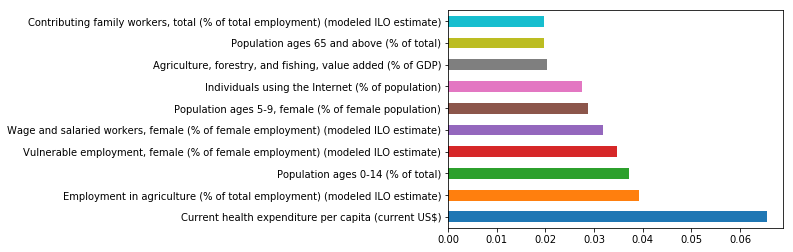

In [17]:
# Tree based
X = Xn_train # Independent columns
y = y_train   # Target column

# Instantiate model
model = ExtraTreesClassifier(random_state=10)
model.fit(X,y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feat_importances.sort_values(ascending=False).head(10))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [18]:
# Univariate 
X = Xn_train  # Independent columns
y = y_train    # Target column

# Apply SelectKBest class to extract top 25 best features
# f_classif uses Anova testing
bestfeatures = SelectKBest(score_func=f_classif, k=25)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # Name the dataframe columns
print(featureScores.nlargest(25,'Score'))  # Print 25 best features

                                                 Specs        Score
310  Vulnerable employment, female (% of female emp...  2038.150086
312  Vulnerable employment, total (% of total emplo...  2014.566371
313  Wage and salaried workers, female (% of female...  1974.988770
286  Self-employed, female (% of female employment)...  1974.988652
315  Wage and salaried workers, total (% of total e...  1944.937167
288  Self-employed, total (% of total employment) (...  1944.936885
62   Employment in agriculture, male (% of male emp...  1873.853434
60   Employment in agriculture (% of total employme...  1861.056622
311  Vulnerable employment, male (% of male employm...  1792.045514
0    Access to clean fuels and technologies for coo...  1686.587220
314  Wage and salaried workers, male (% of male emp...  1655.711911
287  Self-employed, male (% of male employment) (mo...  1655.711133
66   Employment in services (% of total employment)...  1645.119885
112   Individuals using the Internet (% of popul

In [84]:
# Create lists for features
both = []
all_features = []
top_20 = []
top_10 = []
feature_score = []
feature_importance = []
    
# Drop features into both list
for item in featureScores.nlargest(25,'Score').Specs:
    if item in list(feat_importances.nlargest(25).index):
        both.append(item)

# Place features into all list
for item in featureScores.nlargest(25,'Score').Specs:
    all_features.append(item)
for item in list(feat_importances.nlargest(25).index):
    all_features.append(item)
    
# Place features into top 20 list
for item in featureScores.nlargest(10,'Score').Specs:
    top_20.append(item)
for item in list(feat_importances.nlargest(10).index):
    top_20.append(item)
    
# Place features into top 10 list
for item in featureScores.nlargest(5,'Score').Specs:
    top_10.append(item)
for item in list(feat_importances.nlargest(5).index):
    top_10.append(item)
    
# Place features into feature_score list
for item in featureScores.nlargest(20,'Score').Specs:
    feature_score.append(item)
    
# Place features into feature_importance list
for item in list(feat_importances.nlargest(20).index):
    feature_importance.append(item)
    
# Drop duplicates in all features list
all_features = list(pd.DataFrame(all_features).drop_duplicates()[0])

# Drop duplicates from top 20
top_17 = list(pd.DataFrame(top_20).drop_duplicates()[0])

# Drop duplicates from top 10
top_8 = list(pd.DataFrame(top_10).drop_duplicates()[0])


     
print('features in both selection methods: {}\nall features selected in both methods: {}'
      .format(len(both), len(all_features)))
print('features in top 20: {}\nfeatures in top 10: {}'
      .format(len(top_17), len(top_8)))

features in both selection methods: 13
all features selected in both methods: 37
features in top 20: 17
features in top 10: 8


# Model Selection, Tuning & Training
create pipeline, select and tune hyperparameters, cross validate on training data (scores are on training data), test on unseen data, record score, adjust parameters according to new data comparing second tuning to gridsearch.

Logistic Regression
KNN
Random Forest
SVM
Gradient Boosting

Random forest , KNN and Gradient Boosting do well with 10 to 20 features.  But SVM and Logistic test in the low 80's

## Random Forest
0.93818

In [21]:
# Create pipeline
pipeline = make_pipeline(RandomForestClassifier())

# Select hyperparameters
hyperparameters = {'randomforestclassifier__max_features': ['sqrt', 'log2', None],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1],
                  'randomforestclassifier__n_estimators': [10, 25, 50, 75, 100]}

# Find best hyperparameters
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
clf.fit(Xn_train[top_17], y_train)
print('Best Parameters: {}'.format(clf.best_params_))
print('Best Score: {}'.format(clf.best_score_))

Best Parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 50}
Best Score: 0.9510613207547169


Accuracy: 0.9395604395604396
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       222
           1       0.89      0.89      0.89       177
           2       0.91      0.92      0.92       192
           3       0.99      0.96      0.98       137

   micro avg       0.94      0.94      0.94       728
   macro avg       0.94      0.94      0.94       728
weighted avg       0.94      0.94      0.94       728



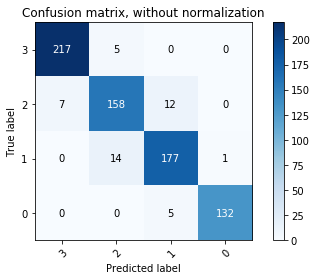

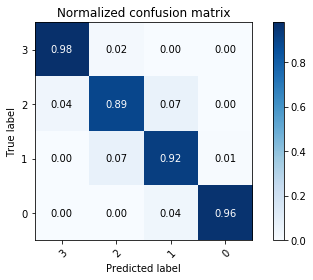

In [109]:
# Test model
select_model(top_17, RandomForestClassifier(random_state=10, 
                            n_estimators=75, 
                            max_features='log2', 
                            max_depth=None))
# Rename dataframe
random_forest = dataframe

## Logistic Regression
0.90659

In [23]:
# Create pipeline
pipeline = make_pipeline(LogisticRegression())

# Select hyperparameters
hyperparameters = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'logisticregression__solver': ['lbfgs', 'sag', 'saga', 'newton-cg']}

# Find best hyperparameters
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
clf.fit(Xn_train[all_features], y_train)
print(clf.best_params_)
print(clf.best_score_)

{'logisticregression__C': 100, 'logisticregression__solver': 'newton-cg'}
0.9033018867924528


Accuracy: 0.9038461538461539
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       222
           1       0.86      0.85      0.85       177
           2       0.86      0.86      0.86       192
           3       0.92      0.95      0.94       137

   micro avg       0.90      0.90      0.90       728
   macro avg       0.90      0.90      0.90       728
weighted avg       0.90      0.90      0.90       728



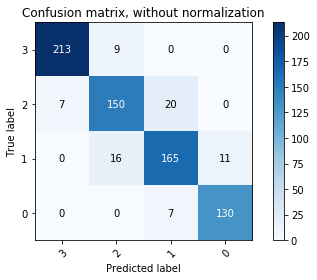

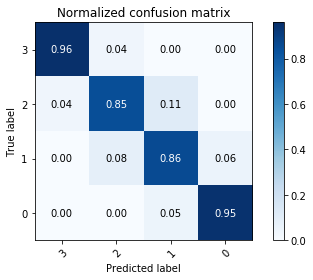

In [119]:
# Test model
select_model(all_features, LogisticRegression(random_state=10, 
                         solver='newton-cg', 
                         multi_class='multinomial', 
                         C=100))
# Rename dataframe
log_reg = dataframe

## Support Vector Machines
top 8 got 0.92582

In [25]:
# Create pipeline
pipeline = make_pipeline(SVC())

# Select hyperparameters
hyperparameters = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'svc__kernel': ['rbf', 'linear'],
                  'svc__gamma': [0.001, 0.01, 0.1, 1]}

# Find best hyperparameters
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
clf.fit(Xn_train[all_features], y_train)
print(clf.best_params_)
print(clf.best_score_)

{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.9510613207547169


Accuracy: 0.9313186813186813
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       222
           1       0.90      0.92      0.91       177
           2       0.90      0.89      0.89       192
           3       0.94      0.93      0.94       137

   micro avg       0.93      0.93      0.93       728
   macro avg       0.93      0.93      0.93       728
weighted avg       0.93      0.93      0.93       728



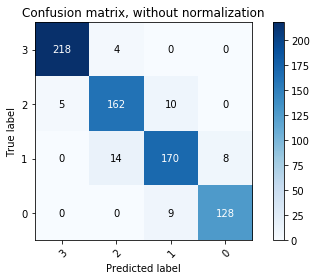

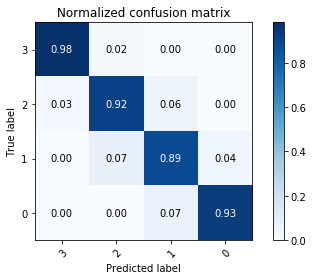

In [111]:
# Test model
select_model(all_features, SVC(random_state=10, 
          C=100, 
          kernel='rbf', 
          gamma=1))
# Rename dataframe
svc = dataframe

## K-Nearest Neighbors
0.92445

In [27]:
# Create pipeline
pipeline = make_pipeline(KNeighborsClassifier())

# Select hyperparameters
hyperparameters = {'kneighborsclassifier__n_neighbors': np.arange(1,10)}

# Find best hyperparameters
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
clf.fit(Xn_train[feature_importance], y_train)
print(clf.best_params_)
print(clf.best_score_)

{'kneighborsclassifier__n_neighbors': 1}
0.9528301886792453


Accuracy: 0.9271978021978022
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       222
           1       0.90      0.90      0.90       177
           2       0.89      0.88      0.89       192
           3       0.93      0.93      0.93       137

   micro avg       0.93      0.93      0.93       728
   macro avg       0.93      0.92      0.92       728
weighted avg       0.93      0.93      0.93       728



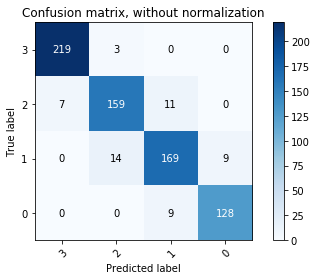

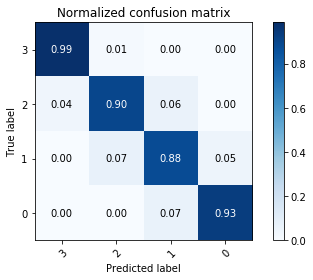

In [112]:
# Test model
select_model(feature_importance, KNeighborsClassifier(n_neighbors=1))

# Rename dataframe
knn = dataframe

## Gradient Boost
0.93406

In [29]:
# Create pipeline
pipeline = make_pipeline(GradientBoostingClassifier())

# Select hyperparameters
hyperparameters = {'gradientboostingclassifier__max_features': ['sqrt', 'log2']}

# Find best hyperparameters
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
clf.fit(Xn_train[top_17], y_train)
print(clf.best_params_)
print(clf.best_score_)

{'gradientboostingclassifier__max_features': 'sqrt'}
0.9475235849056604


Accuracy: 0.9368131868131868
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       222
           1       0.90      0.92      0.91       177
           2       0.92      0.91      0.92       192
           3       0.96      0.95      0.95       137

   micro avg       0.94      0.94      0.94       728
   macro avg       0.94      0.94      0.94       728
weighted avg       0.94      0.94      0.94       728



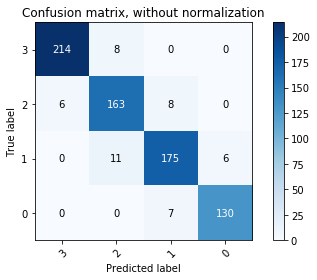

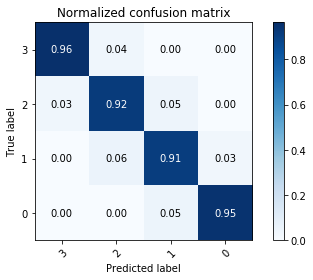

In [113]:
# Test model
select_model(top_17, GradientBoostingClassifier(random_state=10, 
                            n_estimators=50, 
                            max_features='sqrt', 
                            max_depth=None))
# Rename dataframe
gradient_boost = dataframe

# Compare Models

In [31]:
# Dataframes created and renamed after each model have testing scores

# Create dataframe
average = pd.DataFrame()

# Combine the mean of each testing score of each model
average[['random_forest', 
         'log_reg', 
         'svc', 
         'knn', 
         'gradient_boost']] = pd.concat(
                                [random_forest.iloc[:4,:3].mean(), 
                                log_reg.iloc[:5,:3].mean(), 
                                svc.iloc[:4,:3].mean(), 
                                knn.iloc[:4,:3].mean(), 
                                gradient_boost.iloc[:4,:3].mean()], 
                                axis=1)

# Add accuracy score to average score
accuracy = {'random_forest': random_forest.iloc[-3,:3].mean(), 
            'log_reg': log_reg.iloc[-3,:3].mean(), 
            'svc': svc.iloc[-3,:3].mean(), 
            'knn': knn.iloc[-3,:3].mean(),  
            'gradient_boost': gradient_boost.iloc[-3,:3].mean()}

accuracy = pd.Series(accuracy).rename('accuracy')
average = average.append(accuracy)

# Create empty dataframes and put into list
high_score = pd.DataFrame()
um_score = pd.DataFrame()
lm_score = pd.DataFrame()
low_score = pd.DataFrame()
scores = [high_score, um_score, lm_score, low_score]


# Obtain testing scores for each model according to income group
for i, score in enumerate(scores):
    score = pd.concat(
                [random_forest.iloc[i,:3], 
                log_reg.iloc[i,:3], 
                svc.iloc[i,:3], 
                knn.iloc[i,:3], 
                gradient_boost.iloc[i,:3]], 
                axis=1)
    
    score.columns = ['random_forest', 
                     'log_reg', 
                     'svc', 
                     'knn', 
                     'gradient_boost']
    # Assign to list of dataframes
    scores[i] = score

# Assign dataframes to scores
high_score = scores[0]
um_score = scores[1]
lm_score = scores[2]
low_score = scores[3]

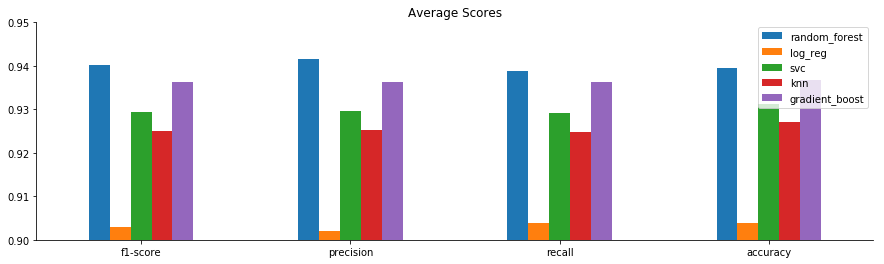

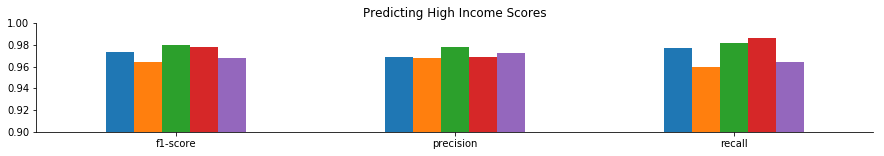

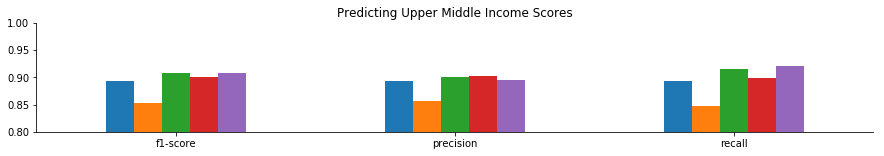

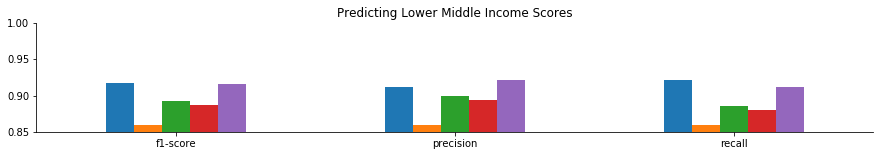

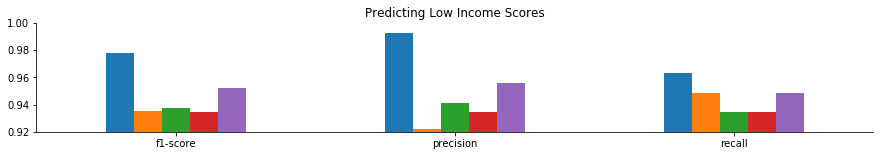

In [114]:
# Plot average scores and accuracy
average.plot(kind='bar', figsize=(15,4))
plt.legend(loc='upper right')
plt.ylim(0.9,0.95)
plt.title('Average Scores')
plt.xticks(rotation=0)
sns.despine(right=True, top=True)
plt.show()

# Plot scores in predicting each income group
limits = [0.9, 0.8, 0.85, 0.92]
names=['Predicting High Income Scores', 
       'Predicting Upper Middle Income Scores', 
       'Predicting Lower Middle Income Scores', 
       'Predicting Low Income Scores']
for score, limit, name in zip(scores, limits, names):
    score.plot(kind='bar', figsize=(15,2), legend=None)
    plt.ylim(limit,1)
    plt.title(name)
    plt.xticks(rotation=0)
    sns.despine(right=True, top=True)
    plt.show()

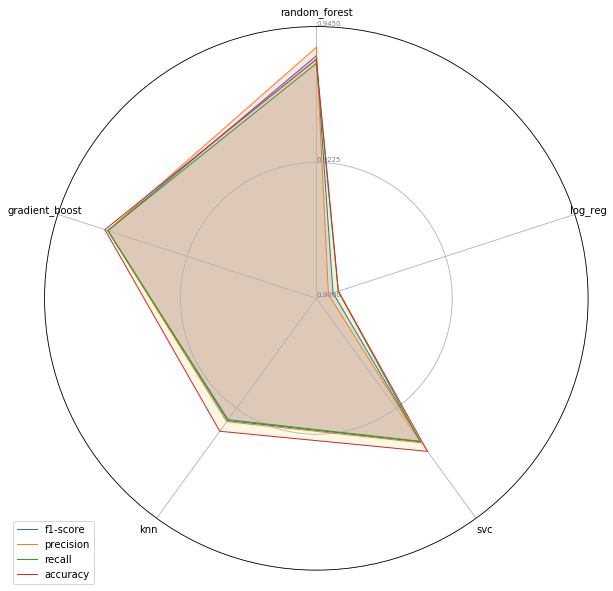

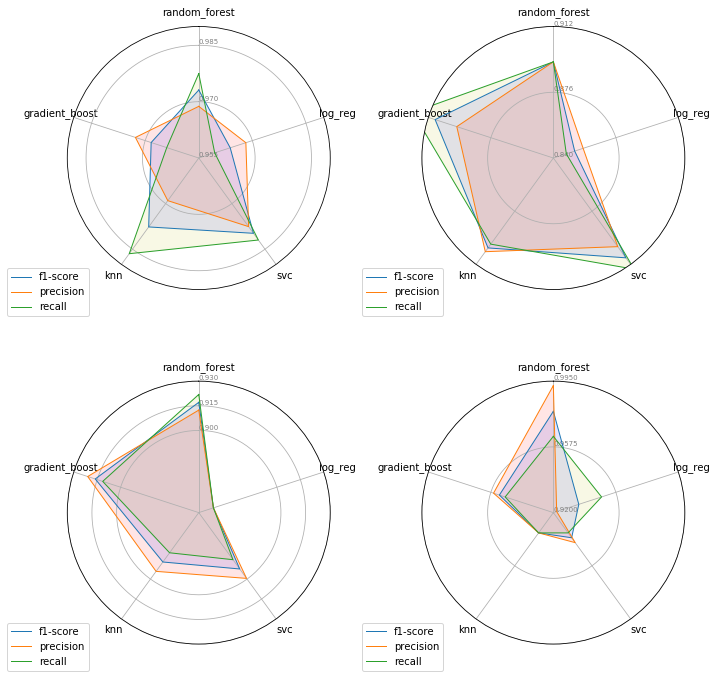

In [115]:
spider_plot()

# Compare Predictions with Various Feature Selection

Each type of feature selection needs it's own tuning.  But just a showcase of how various numbers of features affect the prediction.  Got the highest accuracy from 50 features

### Random Forest

In [73]:
# Set up for loop
default = list(Xn_train.columns)
features = [default, all_features, both, top_17, top_8, feature_score, feature_importance]
names = ['All Features', 'All 37 Features from Selection Methods', 'Features in Both Selection Methods', 
         'Top 17 Features', 'Top 8 Features', 'Univariate Feature Selection', 'Tree-Based Feature Selection']

for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, RandomForestClassifier(random_state=10, 
                                n_estimators=75, 
                                max_features='sqrt', 
                                max_depth=None))
    print('\n')

All Features
Accuracy: 0.929945054945055


All 37 Features from Selection Methods
Accuracy: 0.9340659340659341


Features in Both Selection Methods
Accuracy: 0.9217032967032966


Top 17 Features
Accuracy: 0.9395604395604396


Top 8 Features
Accuracy: 0.9162087912087912


Univariate Feature Selection
Accuracy: 0.9354395604395604


Tree-Based Feature Selection
Accuracy: 0.9354395604395604




### Logistic Regression

In [74]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, LogisticRegression(random_state=10, 
                                 solver='newton-cg', 
                                 multi_class='multinomial', 
                                 C=100))
    print('\n')

All Features
Accuracy: 0.9271978021978022


All 37 Features from Selection Methods
Accuracy: 0.9038461538461539


Features in Both Selection Methods
Accuracy: 0.8269230769230769


Top 17 Features
Accuracy: 0.8722527472527473


Top 8 Features
Accuracy: 0.8324175824175825


Univariate Feature Selection
Accuracy: 0.8722527472527473


Tree-Based Feature Selection
Accuracy: 0.8846153846153846




### Support Vector Machines

In [75]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, SVC(random_state=10, 
                                  C=100, 
                                  kernel='rbf', 
                                  gamma=1))
    print('\n')

All Features
Accuracy: 0.32142857142857145


All 37 Features from Selection Methods
Accuracy: 0.9313186813186813


Features in Both Selection Methods
Accuracy: 0.9120879120879121


Top 17 Features
Accuracy: 0.9175824175824175


Top 8 Features
Accuracy: 0.9258241758241759


Univariate Feature Selection
Accuracy: 0.9148351648351648


Tree-Based Feature Selection
Accuracy: 0.9285714285714286




### K-Nearest Neighbores

In [76]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, KNeighborsClassifier(n_neighbors=1))
    print('\n')

All Features
Accuracy: 0.9107142857142857


All 37 Features from Selection Methods
Accuracy: 0.9271978021978022


Features in Both Selection Methods
Accuracy: 0.9162087912087912


Top 17 Features
Accuracy: 0.9217032967032966


Top 8 Features
Accuracy: 0.9217032967032966


Univariate Feature Selection
Accuracy: 0.9189560439560439


Tree-Based Feature Selection
Accuracy: 0.9271978021978022




### Gradient Boost

In [77]:
for feature, name in zip(features, names):
    print(name)
    # Test model
    select_models(feature, GradientBoostingClassifier(random_state=10, 
                                n_estimators=50, 
                                max_features='sqrt', 
                                max_depth=None))
    print('\n')

All Features
Accuracy: 0.9409340659340659


All 37 Features from Selection Methods
Accuracy: 0.9313186813186813


Features in Both Selection Methods
Accuracy: 0.9340659340659341


Top 17 Features
Accuracy: 0.9368131868131868


Top 8 Features
Accuracy: 0.9244505494505495


Univariate Feature Selection
Accuracy: 0.9368131868131868


Tree-Based Feature Selection
Accuracy: 0.9313186813186813


